In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
class CFG:
    id_ = '58526'
    game_play = '58526_001849'
    frame = 414
    input_dir = '/kaggle/input/nfl-player-contact-detection'
    image_dir = '/kaggle/input/nfl-contact-extracted-train-frames/content/work/frames/train/'
    train_vid_dir = os.path.join(input_dir, 'train')
    train_helmets_dir = os.path.join(input_dir, 'train_baseline_helmets.csv')
    train_labels_dir = os.path.join(input_dir, 'train_labels.csv')
    train_tracking_dir = os.path.join(input_dir, 'train_player_tracking.csv')
    
    def expand_contact_id(df):
        df['game_play'] = df['contact_id'].str[:12]
        df['game'] = df['contact_id'].apply(lambda s: s.split('_')[0])
        df['play'] = df['contact_id'].apply(lambda s: s.split('_')[1])
        df['step'] = df['contact_id'].apply(lambda s: s.split('_')[2]).astype(int)
        df['nfl_player_id_1'] = df['contact_id'].apply(lambda s: s.split('_')[-2])
        df['nfl_player_id_2'] = df['contact_id'].apply(lambda s: s.split('_')[-1])
        return df
    
    def merge_helmet_views(helmets):
        df = helmets.drop(columns=['play_id', 'video'])
        on_cols = ['game_key', 'game_play', 'frame', 'nfl_player_id', 'player_label']
        df_view = df[df['view']=='Endzone'].merge(
            df[df['view']=='Sideline'], on=on_cols, how='outer', suffixes=['_end', '_side'])
        del df_view['view_end'], df_view['view_side'], df_view['player_label']
        return df_view

In [3]:
videos = os.listdir(CFG.train_vid_dir)
images = sorted(os.listdir(CFG.image_dir))
labels = pd.read_csv(CFG.train_labels_dir)
track = pd.read_csv(CFG.train_tracking_dir)
helmets = pd.read_csv(CFG.train_helmets_dir)

In [4]:
ex_vids = list(filter(lambda x: CFG.id_ in x and 'All' not in x, videos))
ex_vids

['58526_001849_Sideline.mp4', '58526_001849_Endzone.mp4']

In [5]:
!mkdir -p ../work/frames
for video in ex_vids:
    !ffmpeg -i /kaggle/input/nfl-player-contact-detection/train/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

In [6]:
ex_images = list(filter(lambda x: CFG.id_ in x, images))

In [7]:
def create_features(df_label, df_tracking, cols, merge_col="step"):
    df_combo = (
        df_label.astype({"nfl_player_id_1": str, "nfl_player_id_2": str})
        .merge(
            df_tracking[["game_play", merge_col, "nfl_player_id"] + cols]
                .astype({"nfl_player_id": "str"}),
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",)
        .drop(columns=["nfl_player_id"])
        .merge(
            df_tracking[["game_play", merge_col, "nfl_player_id"] + cols]
                .astype({"nfl_player_id": "str"}),
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
            suffixes=['_1', '_2']
        )
        .drop(columns=["nfl_player_id"])
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    df_combo['G_flag'] = (df_combo['nfl_player_id_2']=='G').astype(int)
    
    df_combo['distance_x'] = np.abs(df_combo['x_position_1']-df_combo['x_position_2'])
    df_combo['distance_y'] = np.abs(df_combo['y_position_1']-df_combo['y_position_2'])
    dist_pow = df_combo['distance_x']**2 + df_combo['distance_y']**2
    df_combo['distance'] = np.sqrt(dist_pow)
        
    return df_combo

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

feats = ['contact_id', 'contact', 'G_flag', 'x_position_1',
       'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1',
       'acceleration_1', 'sa_1', 'x_position_2', 'y_position_2', 'speed_2',
       'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
       'distance', ]

df_train = create_features(labels, track, use_cols)

In [8]:
df_train = CFG.expand_contact_id(df_train)
df_train['frame'] = np.round(df_train['step']/10*59.94+5*59.94).astype(int)
ex_train = df_train[df_train['game']==CFG.id_]

In [9]:
# Could have N/A values due to different video length
df_helmets = CFG.merge_helmet_views(helmets)
ex_helmets = df_helmets[df_helmets['game_key']==int(CFG.id_)]
ex_helmets

game_play  game_key  frame  nfl_player_id  left_end  width_end  \
1293233  58526_001849     58526    290          42116     890.0       17.0   
1293234  58526_001849     58526    290          35466     673.0       16.0   
1293235  58526_001849     58526    290          53431     673.0       14.0   
1293236  58526_001849     58526    290          46775     268.0       18.0   
1293237  58526_001849     58526    290          42428     889.0       13.0   
...               ...       ...    ...            ...       ...        ...   
2112691  58526_001849     58526    511          43522       NaN        NaN   
2112692  58526_001849     58526    512          43522       NaN        NaN   
2112693  58526_001849     58526    513          43522       NaN        NaN   
2112694  58526_001849     58526    514          43522       NaN        NaN   
2112695  58526_001849     58526    515          43522       NaN        NaN   

         top_end  height_end  left_side  width_side  top_side  height_side  
1293233    399.0        17.0      674.0        11.0     278.0         10.0  
1293234    571.0        17.0      937.0        11.0     342.0         10.0  
1293235    325.0        19.0        NaN         NaN       NaN          NaN  
1293236    428.0        16.0      672.0         9.0     417.0          9.0  
1293237    354.0        19.0      544.0         9.0     285.0         10.0  
...          ...         ...        ...         ...       ...          ...  
2112691      NaN         NaN      604.0        10.0     210.0         11.0  
2112692      NaN         NaN      600.0        10.0     210.0         10.0  
2112693      NaN         NaN      596.0        10.0     211.0         11.0  
2112694      NaN         NaN      592.0        10.0     212.0         11.0  
2112695      NaN         NaN      586.0        11.0     213.0         11.0  

[4972 rows x 12 columns]

In [10]:
def merge_label_helmet(label, helmet):
    if 'frame' not in label.columns:
        label['frame'] = np.round(label['step']/10*59.94+5*59.94).astype(int)
    helmet = helmet.copy(deep=True)
    helmet['nfl_player_id'] = helmet['nfl_player_id'].astype(str)
    df = label.merge(helmet, 
                     left_on=['game_play', 'frame', 'nfl_player_id_1'],
                     right_on=['game_play', 'frame', 'nfl_player_id'],
                     how='left')
    df = df.merge(helmet, 
                     left_on=['game_play', 'frame', 'nfl_player_id_2'],
                     right_on=['game_play', 'frame', 'nfl_player_id'],
                     how='left', suffixes=['_p1','_p2'])
    df = df.drop(columns=['nfl_player_id_p1', 'nfl_player_id_p2'])
    return df

In [11]:
d = merge_label_helmet(ex_train, ex_helmets)
d = d[d['distance']<2.25]
d = d[(d['game_play']==CFG.game_play) & (d['frame']==CFG.frame)]

In [12]:
d.columns

Index(['contact_id', 'game_play', 'datetime', 'step', 'nfl_player_id_1',
       'nfl_player_id_2', 'contact', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2',
       'orientation_2', 'acceleration_2', 'sa_2', 'G_flag', 'distance_x',
       'distance_y', 'distance', 'game', 'play', 'frame', 'game_key_p1',
       'left_end_p1', 'width_end_p1', 'top_end_p1', 'height_end_p1',
       'left_side_p1', 'width_side_p1', 'top_side_p1', 'height_side_p1',
       'game_key_p2', 'left_end_p2', 'width_end_p2', 'top_end_p2',
       'height_end_p2', 'left_side_p2', 'width_side_p2', 'top_side_p2',
       'height_side_p2'],
      dtype='object')

In [13]:
sorted(set(d['frame']))

[414]

In [14]:
!mkdir -p ../work/frames
for video in tqdm(ex_vids):
    !ffmpeg -i /kaggle/input/nfl-player-contact-detection/train/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


In [15]:
d

contact_id     game_play                  datetime  \
4829  58526_001849_19_39684_40149  58526_001849  2021-09-19T18:22:06.100Z   
4830  58526_001849_19_39684_41295  58526_001849  2021-09-19T18:22:06.100Z   
4833  58526_001849_19_39684_43079  58526_001849  2021-09-19T18:22:06.100Z   
4834  58526_001849_19_39684_43433  58526_001849  2021-09-19T18:22:06.100Z   
4839  58526_001849_19_39684_46212  58526_001849  2021-09-19T18:22:06.100Z   
4845  58526_001849_19_39684_52468  58526_001849  2021-09-19T18:22:06.100Z   
4846  58526_001849_19_39684_53431  58526_001849  2021-09-19T18:22:06.100Z   
4847  58526_001849_19_39684_53443  58526_001849  2021-09-19T18:22:06.100Z   
4850  58526_001849_19_40149_41295  58526_001849  2021-09-19T18:22:06.100Z   
4859  58526_001849_19_40149_46212  58526_001849  2021-09-19T18:22:06.100Z   
4865  58526_001849_19_40149_52468  58526_001849  2021-09-19T18:22:06.100Z   
4872  58526_001849_19_41295_43079  58526_001849  2021-09-19T18:22:06.100Z   
4873  58526_001849_19_41295_43433  58526_001849  2021-09-19T18:22:06.100Z   
4878  58526_001849_19_41295_46212  58526_001849  2021-09-19T18:22:06.100Z   
4884  58526_001849_19_41295_52468  58526_001849  2021-09-19T18:22:06.100Z   
4885  58526_001849_19_41295_53431  58526_001849  2021-09-19T18:22:06.100Z   
4915  58526_001849_19_42428_47860  58526_001849  2021-09-19T18:22:06.100Z   
4924  58526_001849_19_43079_43433  58526_001849  2021-09-19T18:22:06.100Z   
4929  58526_001849_19_43079_46212  58526_001849  2021-09-19T18:22:06.100Z   
4935  58526_001849_19_43079_52468  58526_001849  2021-09-19T18:22:06.100Z   
4936  58526_001849_19_43079_53431  58526_001849  2021-09-19T18:22:06.100Z   
4937  58526_001849_19_43079_53443  58526_001849  2021-09-19T18:22:06.100Z   
4942  58526_001849_19_43433_43586  58526_001849  2021-09-19T18:22:06.100Z   
4944  58526_001849_19_43433_46212  58526_001849  2021-09-19T18:22:06.100Z   
4949  58526_001849_19_43433_52445  58526_001849  2021-09-19T18:22:06.100Z   
4950  58526_001849_19_43433_52468  58526_001849  2021-09-19T18:22:06.100Z   
4951  58526_001849_19_43433_53431  58526_001849  2021-09-19T18:22:06.100Z   
4952  58526_001849_19_43433_53443  58526_001849  2021-09-19T18:22:06.100Z   
4953  58526_001849_19_43433_53467  58526_001849  2021-09-19T18:22:06.100Z   
4986  58526_001849_19_43586_47969  58526_001849  2021-09-19T18:22:06.100Z   
4988  58526_001849_19_43586_52445  58526_001849  2021-09-19T18:22:06.100Z   
4990  58526_001849_19_43586_53431  58526_001849  2021-09-19T18:22:06.100Z   
4991  58526_001849_19_43586_53443  58526_001849  2021-09-19T18:22:06.100Z   
4992  58526_001849_19_43586_53467  58526_001849  2021-09-19T18:22:06.100Z   
5009  58526_001849_19_46212_52445  58526_001849  2021-09-19T18:22:06.100Z   
5010  58526_001849_19_46212_52468  58526_001849  2021-09-19T18:22:06.100Z   
5011  58526_001849_19_46212_53431  58526_001849  2021-09-19T18:22:06.100Z   
5012  58526_001849_19_46212_53443  58526_001849  2021-09-19T18:22:06.100Z   
5013  58526_001849_19_46212_53467  58526_001849  2021-09-19T18:22:06.100Z   
5035  58526_001849_19_47969_53431  58526_001849  2021-09-19T18:22:06.100Z   
5036  58526_001849_19_47969_53443  58526_001849  2021-09-19T18:22:06.100Z   
5047  58526_001849_19_52445_53443  58526_001849  2021-09-19T18:22:06.100Z   
5048  58526_001849_19_52445_53467  58526_001849  2021-09-19T18:22:06.100Z   
5054  58526_001849_19_53431_53443  58526_001849  2021-09-19T18:22:06.100Z   
5055  58526_001849_19_53431_53467  58526_001849  2021-09-19T18:22:06.100Z   
5057  58526_001849_19_53443_53467  58526_001849  2021-09-19T18:22:06.100Z   

      step nfl_player_id_1 nfl_player_id_2  contact  x_position_1  \
4829    19           39684           40149        0         84.78   
4830    19           39684           41295        0         84.78   
4833    19           39684           43079        0         84.78   
4834    19           39684           43433        0         84.78   
4839    19           39684           46212        0       

In [16]:
contact_id = '58526_001849_19_39684_40149'

In [17]:
img_end_path = os.path.join(CFG.image_dir, f'{CFG.game_play}_Endzone.mp4_{CFG.frame:04d}.jpg')
img_side_path = os.path.join(CFG.image_dir, f'{CFG.game_play}_Sideline.mp4_{CFG.frame:04d}.jpg')

In [18]:
d_ = d[d['contact_id']==contact_id]
p1_end_bbox = tuple(d_[['left_end_p1', 'width_end_p1', 'top_end_p1', 'height_end_p1']].iloc[0])
p2_end_bbox = tuple(d_[['left_end_p2', 'width_end_p2', 'top_end_p2', 'height_end_p2']].iloc[0])
p1_side_bbox = tuple(d_[['left_side_p1', 'width_side_p1', 'top_side_p1', 'height_side_p1']].iloc[0])
p2_side_bbox = tuple(d_[['left_side_p2', 'width_side_p2', 'top_side_p2', 'height_side_p2']].iloc[0])

In [19]:
def plot_bbox(img_path, p1_bbox, p2_bbox):
    img = cv2.imread(img_path)
    # BUG:
    if p1_bbox[0] != None:
        x = int(p1_bbox[0])
        w = int(p1_bbox[1])
        y = int(p1_bbox[2])
        h = int(p1_bbox[3])
        img = cv2.rectangle(
            img, (x, y), (x+w, y+h),
            (255,0,0), 4
        )
    if p2_bbox[0] != None:
        x = int(p2_bbox[0])
        w = int(p2_bbox[1])
        y = int(p2_bbox[2])
        h = int(p2_bbox[3])
        img = cv2.rectangle(
            img, (x, y), (x+w, y+h),
            (0,255,0), 4
        )
        
    return img

In [20]:
img_end = plot_bbox(img_end_path, p1_end_bbox, p2_end_bbox)
img_side = plot_bbox(img_side_path, p1_side_bbox, p2_side_bbox)

## End View

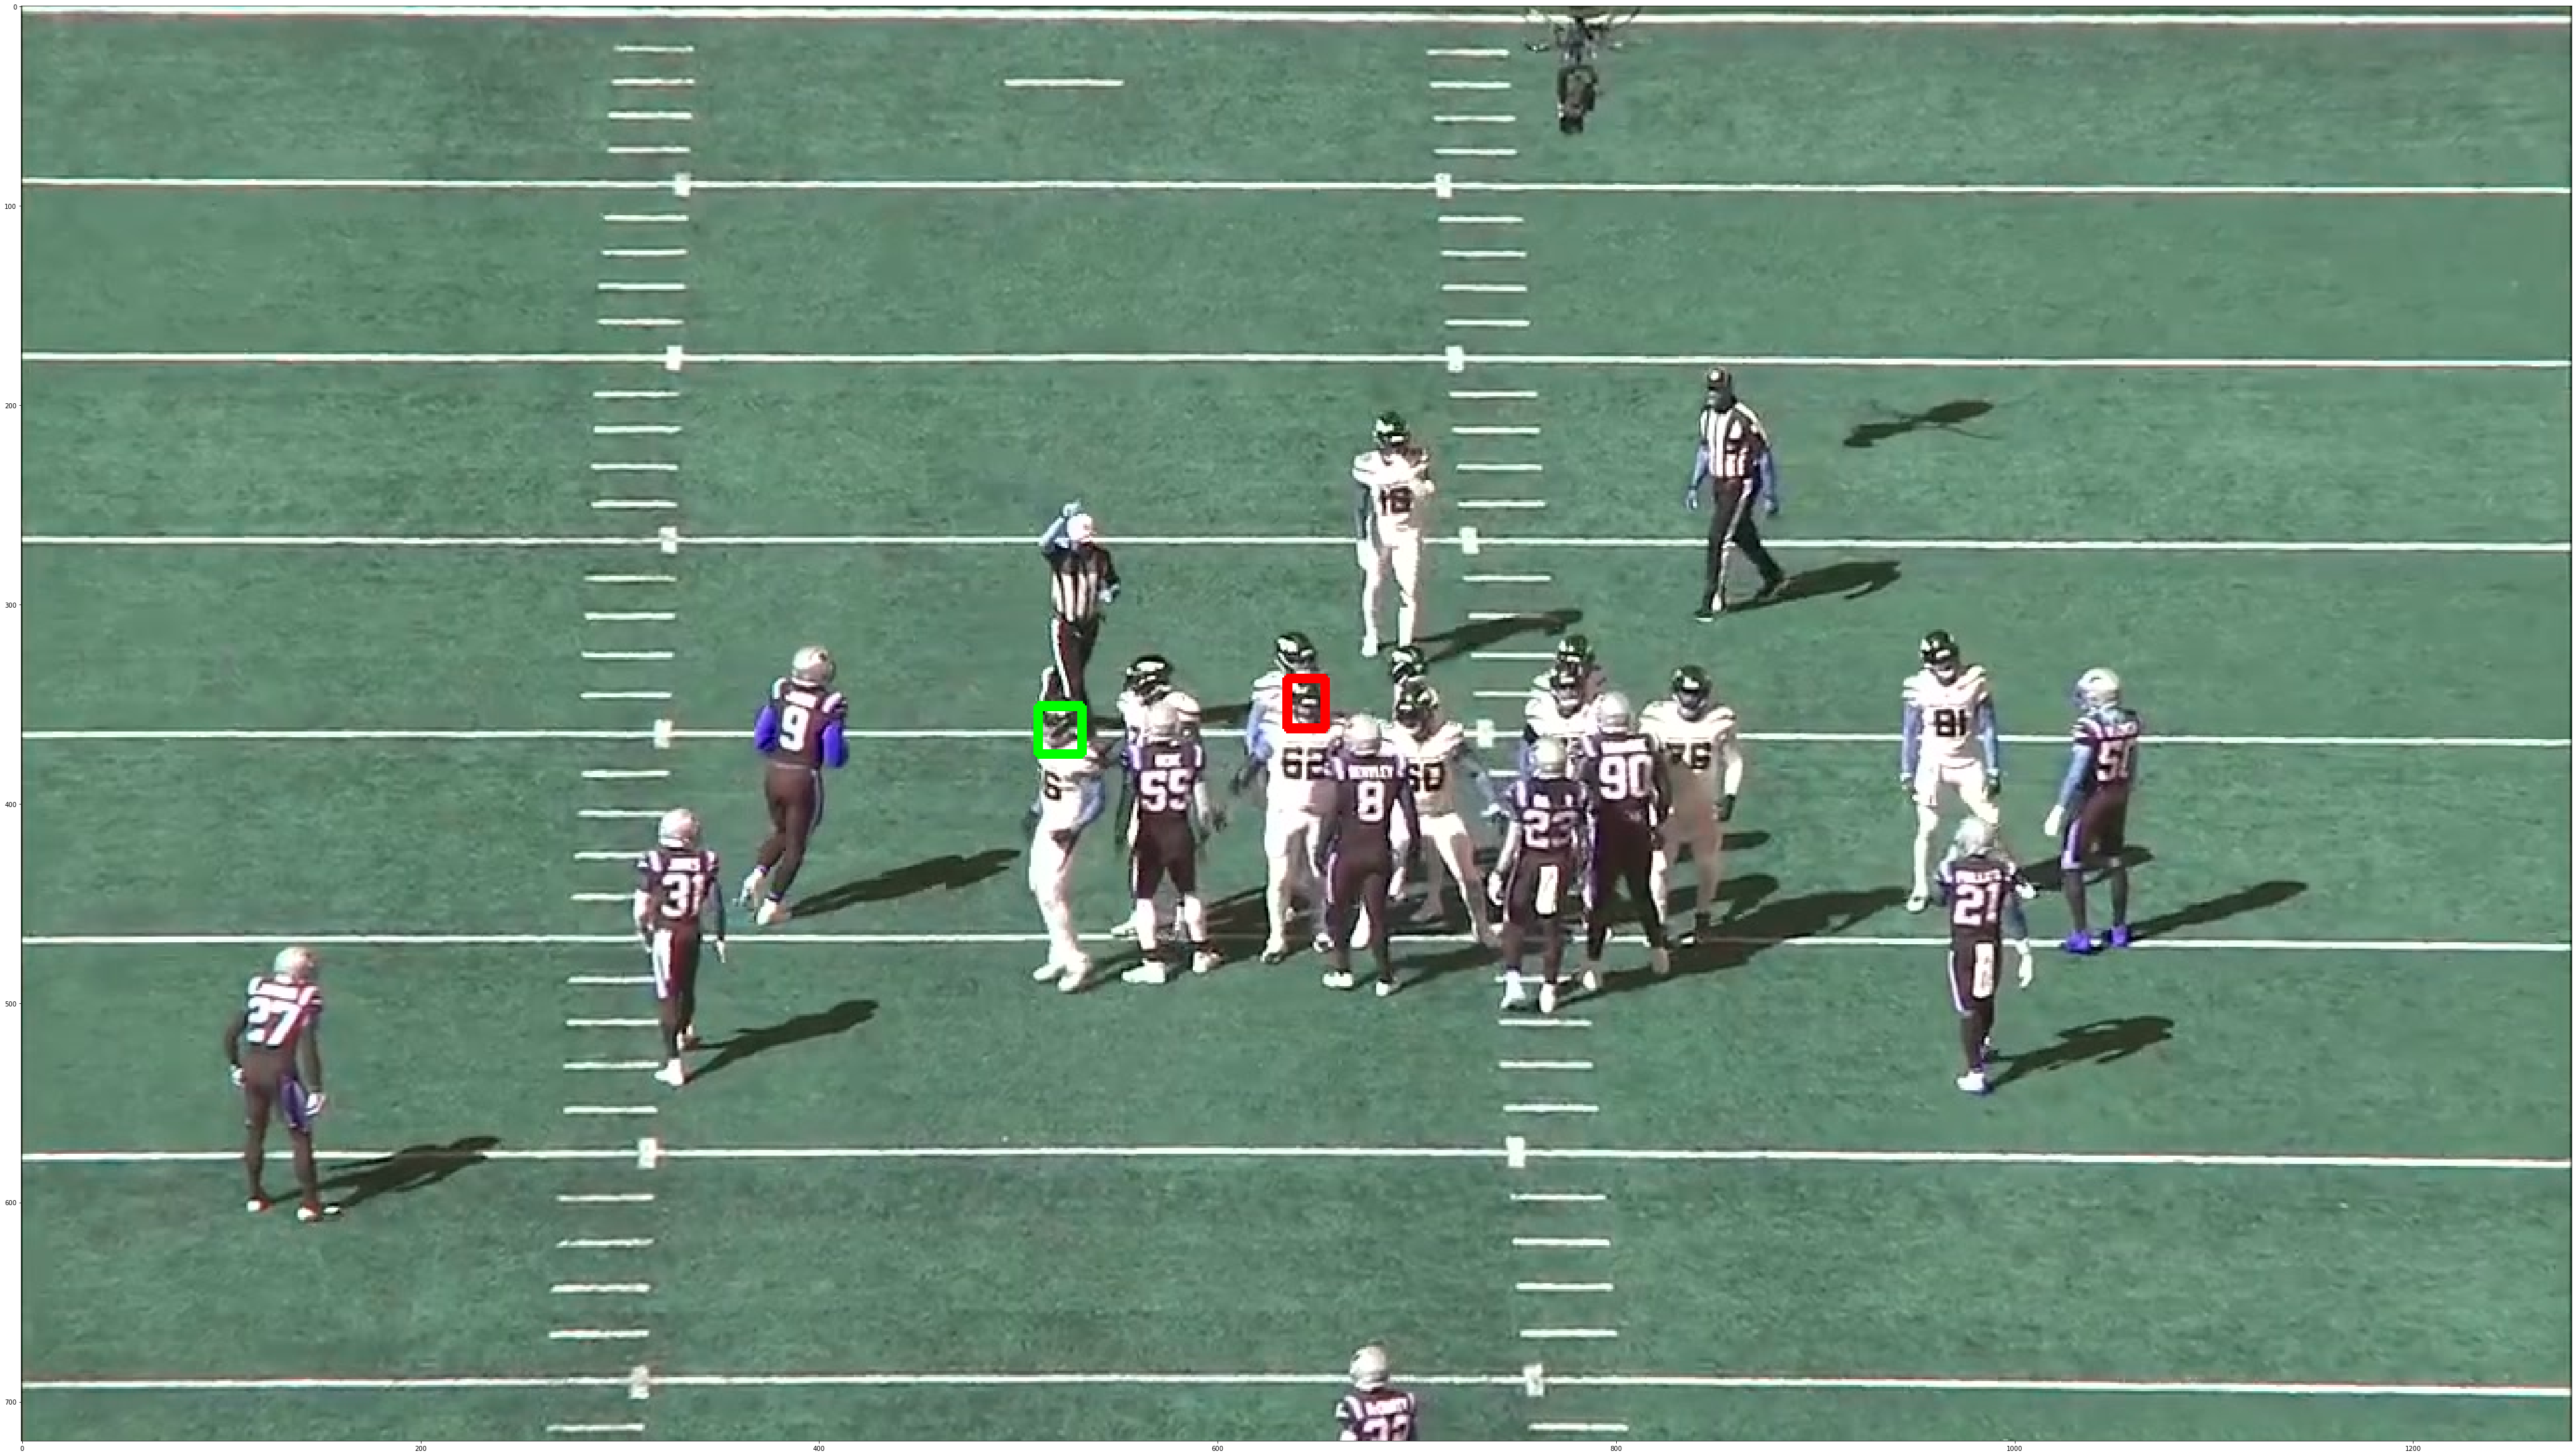

In [21]:
plt.figure(figsize=(72, 128))
plt.imshow(img_end)

## Side View

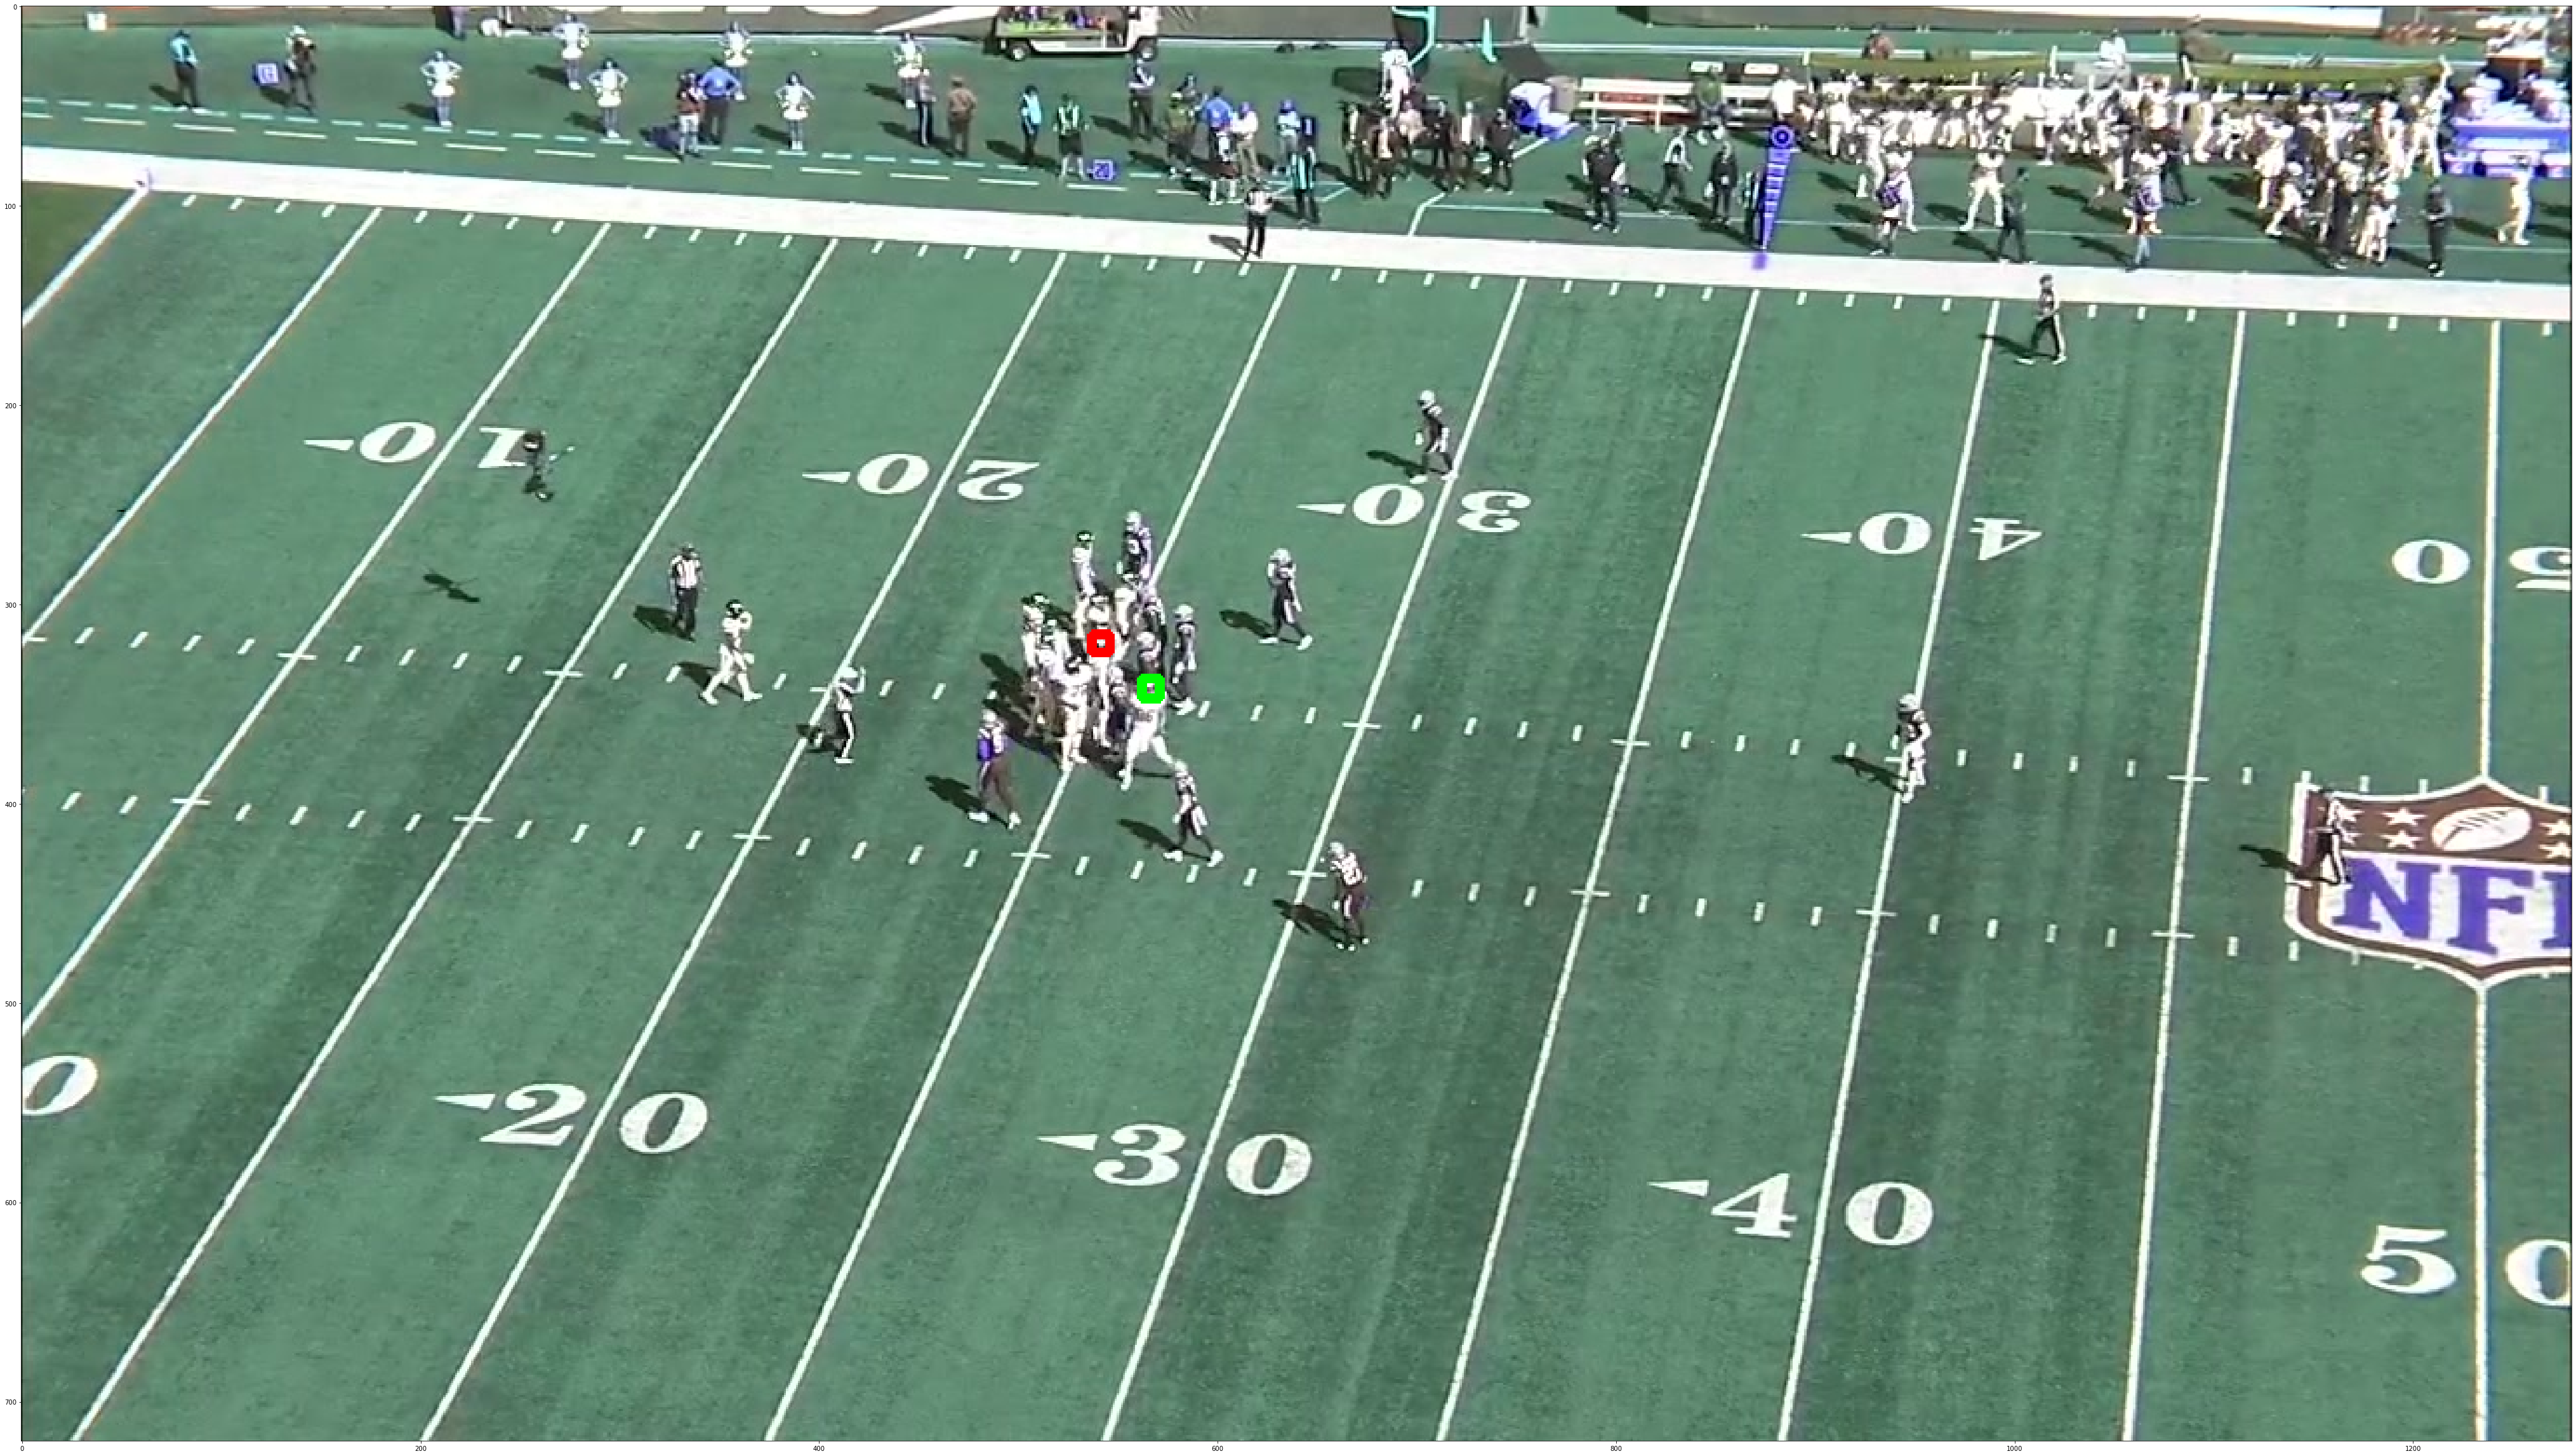

In [22]:
plt.figure(figsize=(72, 128))
plt.imshow(img_side)

## Features

In [23]:
d_.to_dict('records')

[{'contact_id': '58526_001849_19_39684_40149',
  'game_play': '58526_001849',
  'datetime': '2021-09-19T18:22:06.100Z',
  'step': 19,
  'nfl_player_id_1': '39684',
  'nfl_player_id_2': '40149',
  'contact': 0,
  'x_position_1': 84.78,
  'y_position_1': 24.99,
  'speed_1': 0.4,
  'distance_1': 0.04,
  'direction_1': 292.64,
  'orientation_1': 260.35,
  'acceleration_1': 0.4,
  'sa_1': -0.02,
  'x_position_2': 83.89,
  'y_position_2': 26.75,
  'speed_2': 2.52,
  'distance_2': 0.25,
  'direction_2': 241.14,
  'orientation_2': 349.11,
  'acceleration_2': 0.78,
  'sa_2': 0.77,
  'G_flag': 0,
  'distance_x': 0.8900000000000006,
  'distance_y': 1.7600000000000016,
  'distance': 1.9722322378462447,
  'game': '58526',
  'play': '001849',
  'frame': 414,
  'game_key_p1': 58526.0,
  'left_end_p1': 635.0,
  'width_end_p1': 19.0,
  'top_end_p1': 337.0,
  'height_end_p1': 25.0,
  'left_side_p1': 537.0,
  'width_side_p1': 9.0,
  'top_side_p1': 315.0,
  'height_side_p1': 9.0,
  'game_key_p2': 58526.0,